In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from classes import Word2VecModel

In [ ]:
from functions import *
model_w2v_settings = return_best_model()

In [5]:
model_w2v = Word2VecModel(model_w2v_settings)

In [6]:
# read preprocessed data from pickle file
df = pd.read_pickle('data/preprocessed_titles_labels.pkl')
df.head()

,title,is_clickbait
0,"[house, dem, aide, , even, see, comey, letter...",1
1,"[flynn, hillary, clinton, big, woman, campus, ...",0
2,"[truth, might, get, fired]",1
3,"[fifteen, civilian, killed, single, usa, airst...",1
4,"[iranian, woman, jailed, fictional, unpublishe...",1


In [7]:
title_vectors = [get_word_vectors(model_w2v, title, aggregation='mean') for title in df['title']]

X = np.vstack(title_vectors)
y = df['is_clickbait'].values

In [8]:
# split data into train and test stratified by y
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [ ]:
import json

with open('grid_search_results.json', 'r') as f:
    model_settings = json.load(f)

model_settings
grids = model_settings['grid_search_grids']
grids

In [10]:
models_to_CV = list()

for model_name, grid in grids.items():
    # check if model has already been trained - if 'best_params' exists in grid
    if 'best_params' in grid.keys():
        print(f'Model {model_name} already trained')
        continue
    models_to_CV.append((model_name))
models_to_CV

Model lightgbm_grid already trained
Model catboost_grid already trained
Model xgboost_grid already trained
Model random_forest_grid already trained
Model decision_tree_grid already trained


[]

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

for model in grids:
    # check if model has already been trained - if 'best_params' exists in grid - if so, skip
    if not model in models_to_CV:
        continue

    print(f'Grid search for model: {model}')
    grid = grids[model]

    if model == 'decision_tree_grid':
        clf = DecisionTreeClassifier()
    elif model == 'random_forest_grid':
        clf = RandomForestClassifier()
    elif model == 'xgboost_grid':
        clf = XGBClassifier()
    elif model == 'lightgbm_grid':
        clf = LGBMClassifier()
    elif model == 'catboost_grid':
        clf = CatBoostClassifier(verbose=0)

    # do grid search
    grid_search = GridSearchCV(clf, grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_scaled, y_train)

    # save best model
    roc_auc = roc_auc_score(y_test, grid_search.predict_proba(X_test_scaled)[:, 1])
    f1 = f1_score(y_test, grid_search.predict(X_test_scaled))

    grids[model]['best_params'] = grid_search.best_params_
    grids[model]['roc_auc'] = roc_auc
    grids[model]['f1'] = f1

    # save grid search results
    with open('grid_search_results.json', 'w') as f:
        json.dump(model_settings, f)


In [12]:
# order grids by roc_auc descending
grids = {k: v for k, v in sorted(grids.items(), key=lambda item: item[1]['roc_auc'], reverse=True)}

# get model ranking
model_ranking_auc = list()
for model_name, grid in grids.items():
    model_ranking_auc.append((model_name, grid['roc_auc']))

model_ranking_auc 

[('lightgbm_grid', 0.9097654188599116),
 ('catboost_grid', 0.9080895818770095),
 ('xgboost_grid', 0.9077584617708928),
 ('random_forest_grid', 0.871236193125982),
 ('decision_tree_grid', 0.8096845007718035)]

In [13]:
# order grids by f1 descending
grids = {k: v for k, v in sorted(grids.items(), key=lambda item: item[1]['f1'], reverse=True)}

# get model ranking
model_ranking_f1 = list()
for model_name, grid in grids.items():
    model_ranking_f1.append((model_name, grid['f1']))

model_ranking_f1 

[('lightgbm_grid', 0.7896594317981294),
 ('xgboost_grid', 0.788332745858301),
 ('catboost_grid', 0.7863368254247732),
 ('random_forest_grid', 0.7147958691246018),
 ('decision_tree_grid', 0.660548757879125)]

# WINNER - lightgbm

In [ ]:
# get params for best model
best_model = model_ranking_auc[0][0]
best_params = grids[best_model]['best_params']
best_model, best_params

In [ ]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(learning_rate=0.1, max_depth=8, n_estimators=500, num_leaves=248, verbose=0)
clf.fit(X_train_scaled, y_train)

roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test_scaled)[:, 1])
f1 = f1_score(y_test, clf.predict(X_test_scaled))

print(f'ROC AUC: {roc_auc}')
print(f'F1: {f1}')

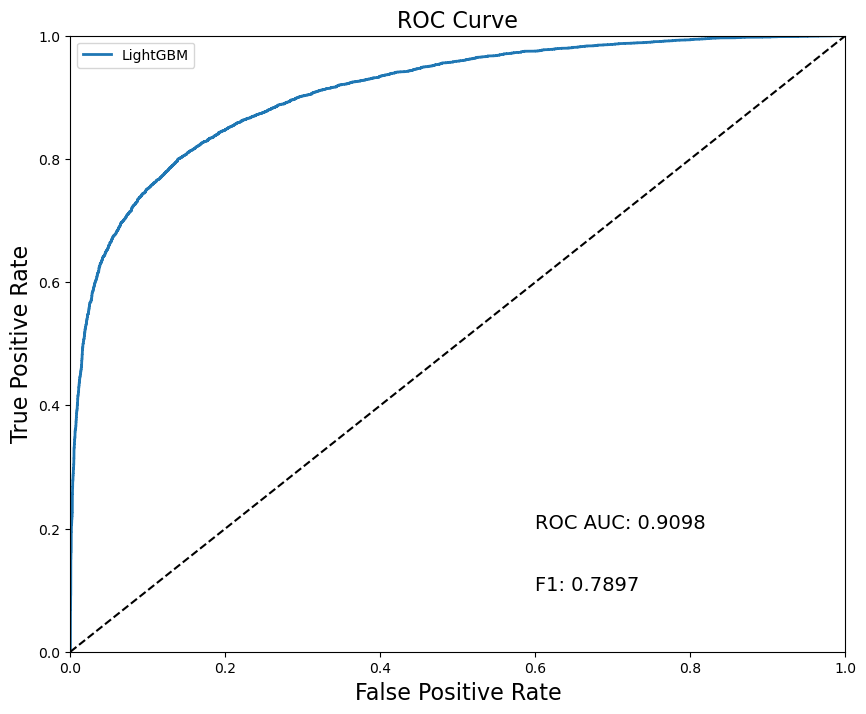

In [16]:
from sklearn.metrics import roc_curve

# plot ROC curve    
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test_scaled)[:, 1])

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2, label='LightGBM')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curve', fontsize=16)
# add info about roc_auc and f1
plt.text(0.6, 0.2, f'ROC AUC: {roc_auc:.4f}', fontsize=14)
plt.text(0.6, 0.1, f'F1: {f1:.4f}', fontsize=14)

plt.legend()
plt.show()

In [17]:
# print confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, clf.predict(X_test_scaled))


array([[8145,  830],
       [1554, 4475]])

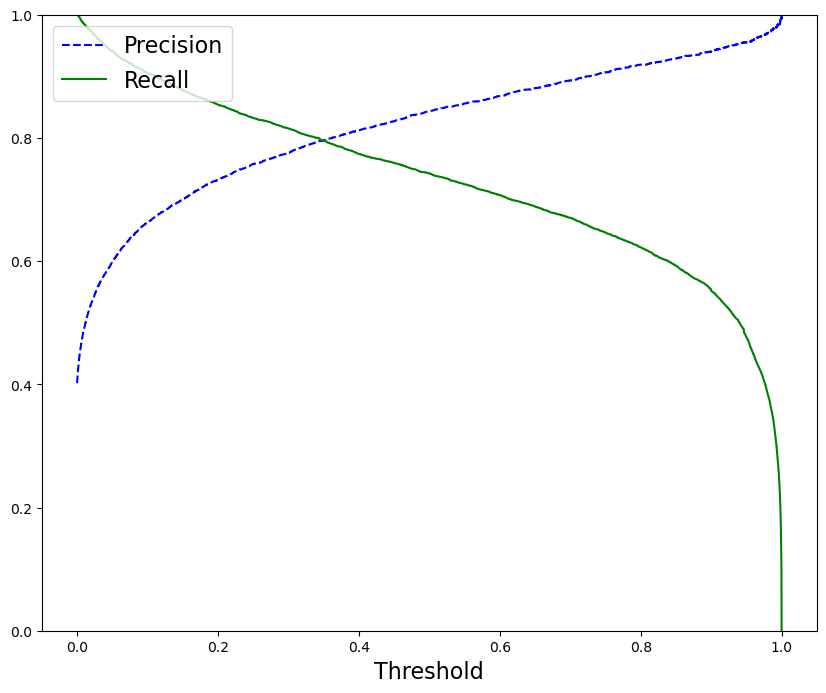

In [18]:
# find best threshold
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test_scaled)[:, 1])

plt.figure(figsize=(10, 8))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold', fontsize=16)
plt.legend(loc='upper left', fontsize=16)
plt.ylim([0, 1])
plt.show()


In [19]:
# get the point at which precision and recall are equal
threshold = thresholds[np.argmax(precisions == recalls)]
threshold

0.3490965225838074

In [20]:
# get predictions for test data with best threshold
y_pred = (clf.predict_proba(X_test_scaled)[:, 1] >= threshold).astype(int)

# print confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)


array([[7745, 1230],
       [1230, 4799]])

In [21]:
# print f1 score
from sklearn.metrics import f1_score

f1_score(y_test, y_pred)

0.7959860673411843

In [23]:
import numpy as np
from tqdm.auto import tqdm
# find threshold for best f1 score
thresholds = np.linspace(0, 1, 10000)
f1s = dict()
for threshold in tqdm(thresholds):
    y_pred = (clf.predict_proba(X_test_scaled)[:, 1] >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1s[threshold] = f1

# get threshold for best f1 score
threshold = max(f1s, key=f1s.get)
threshold
    

  0%|          | 0/10000 [00:00<?, ?it/s]

0.3436343634363436

In [24]:
# find auc and f1 for best threshold
y_pred = (clf.predict_proba(X_test_scaled)[:, 1] >= threshold).astype(int)

roc_auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'ROC AUC: {roc_auc}')
print(f'F1: {f1}')

ROC AUC: 0.8304594829725038
F1: 0.7971877584780811


In [27]:
# save clf to pickle file
import pickle

with open('predictive_models/lightgbm.pkl', 'wb') as f:
    pickle.dump(clf, f)

# save scaler to pickle file
with open('predictive_models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)